# Collecing Data from Web

In [1]:
import pickle
import os
from collections import Counter
from konlpy import tag

In [2]:
text = ""
file_list = os.listdir(path=os.getcwd()+'/Choson_data')

for file in file_list:
    with open('Choson_data/'+file,'rb') as f:
        data = pickle.load(f)
    for day in range(1,len(data)+1):
        for art_num in range(30):
            for st in data[day][art_num]['contents']:
                text += st

In [3]:
Analy = tag.Twitter()
nouns = Analy.nouns(text)
nouns_counter = Counter(nouns)

In [ ]:
nouns_counter.most_common()

In [9]:
with open('embedding_words.pickle','wb') as f:
    pickle.dump(nouns,f,protocol=pickle.HIGHEST_PROTOCOL)

# Check Point

In [16]:
import numpy as np
import pickle
from collections import Counter

with open('embedding_words.pickle','rb') as f:
    nouns = pickle.load(f)

In [18]:
print('Total words:{}'.format(len(nouns)))
print("Unique words:{}".format(len(set(nouns))))

Total words:976047
Unique words:24287


In [19]:
noun_counter = Counter(nouns)

In [ ]:
noun_counter.most_common()[:100]

In [21]:
vocab = sorted(set(nouns),key=noun_counter.get,reverse=True) 
vocab_to_int = {voc : idx for idx,voc in enumerate(vocab) }
int_to_vocab ={idx : voc for idx,voc in enumerate(vocab)}

# Subsampling

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

In [22]:
import random
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\Joon\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


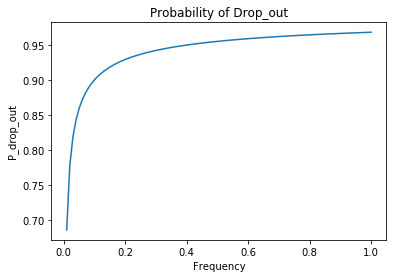

In [23]:
thresholds = 1e-3

x = np.linspace(0,1,100)
y = 1- np.sqrt(thresholds/x)

plt.xlabel('Frequency')
plt.ylabel('P_drop_out')
plt.title('Probability of Drop_out')

plt.plot(x,y)


In [24]:
freqs = {noun:count/len(nouns) for noun,count in noun_counter.items()}
p_drop = {noun: 1-np.sqrt(thresholds/freqs[noun]) for noun in vocab}

In [25]:
train_words = []

for word in nouns:
    if p_drop[word] <= random.random():
        train_words.append(word)

In [26]:
train_words = [vocab_to_int[ch] for ch in train_words]

# Making Batches 

In [27]:
def get_target(text,idx,window_size = 5):
    
    R = np.random.randint(1,window_size+1)
    start = idx - R if (idx-R)>0 else 0
    stop = idx + R
    
    target_words = set(text[start:idx]+text[idx+1:stop+1])
    
    return list(target_words)

In [28]:
def get_batches(text,batch_size,window_size=5):
    
    n_batches = len(text) //batch_size
    text = text[:n_batches*batch_size]
    
    for idx in range(0,len(text),batch_size):
        x,y = [],[]
        batch = text[idx:idx+batch_size]
        
        for ii in range(len(batch)):
            batch_y = get_target(batch,ii,window_size)
            batch_x = batch[ii]
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        
        yield x, y

# Building Graph 

In [29]:
import tensorflow as tf

In [30]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32,[None],name = 'inputs')
    labels = tf.placeholder(tf.int32,[None,None],name = 'labels')

In [31]:
n_vocab = len(vocab)
n_embedding = 200

with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform([n_vocab,n_embedding],-1,1))
    embed = tf.nn.embedding_lookup(embedding,inputs)

# Negative Sampling 

In [32]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Validation  

In [33]:
with train_graph.as_default():
    valid_size = 16
    valid_window = 100
    
    valid_examples = np.array(random.sample(range(valid_window),valid_size//2))
    valid_examples = np.append(valid_examples,
                              random.sample(range(1000,1000+valid_window),valid_size//2))
    
    valid_dataset = tf.constant(valid_examples,dtype=tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding),1,keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding,valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [ ]:
!mkdir checkpoints

# Training... 

In [20]:
import time

In [22]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt
Epoch 1/10 Iteration: 100 Avg. Training loss: 3.6802 0.0245 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 3.6113 0.0241 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 3.4198 0.0240 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 3.5285 0.0240 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 3.6764 0.0241 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 3.6273 0.0241 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 3.6725 0.0241 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 3.7015 0.0240 sec/batch
Epoch 2/10 Iteration: 900 Avg. Training loss: 3.7203 0.0051 sec/batch
Epoch 2/10 Iteration: 1000 Avg. Training loss: 3.6393 0.0240 sec/batch
Nearest to 이번: 패배, 구어, 리포트, 송, 멕시코, 김영호, 기회, 출마,
Nearest to 줄: 생리학, 충족, 씀씀이, 크렘린, 쓴맛, 발문, 이율배반, 탄력,
Nearest to 정책: 무시, 누누이, 정부, 저급, 완전, 뿜어냈, 선진국, 빈곤층,
Nearest to 사람: 언짢아, 아줌마, 주위, 아바타, 한밤중, 보르헤스, 역류, 애완견,
Nearest to 제재: 안보리, 돈줄, 대북, 광

In [34]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [36]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

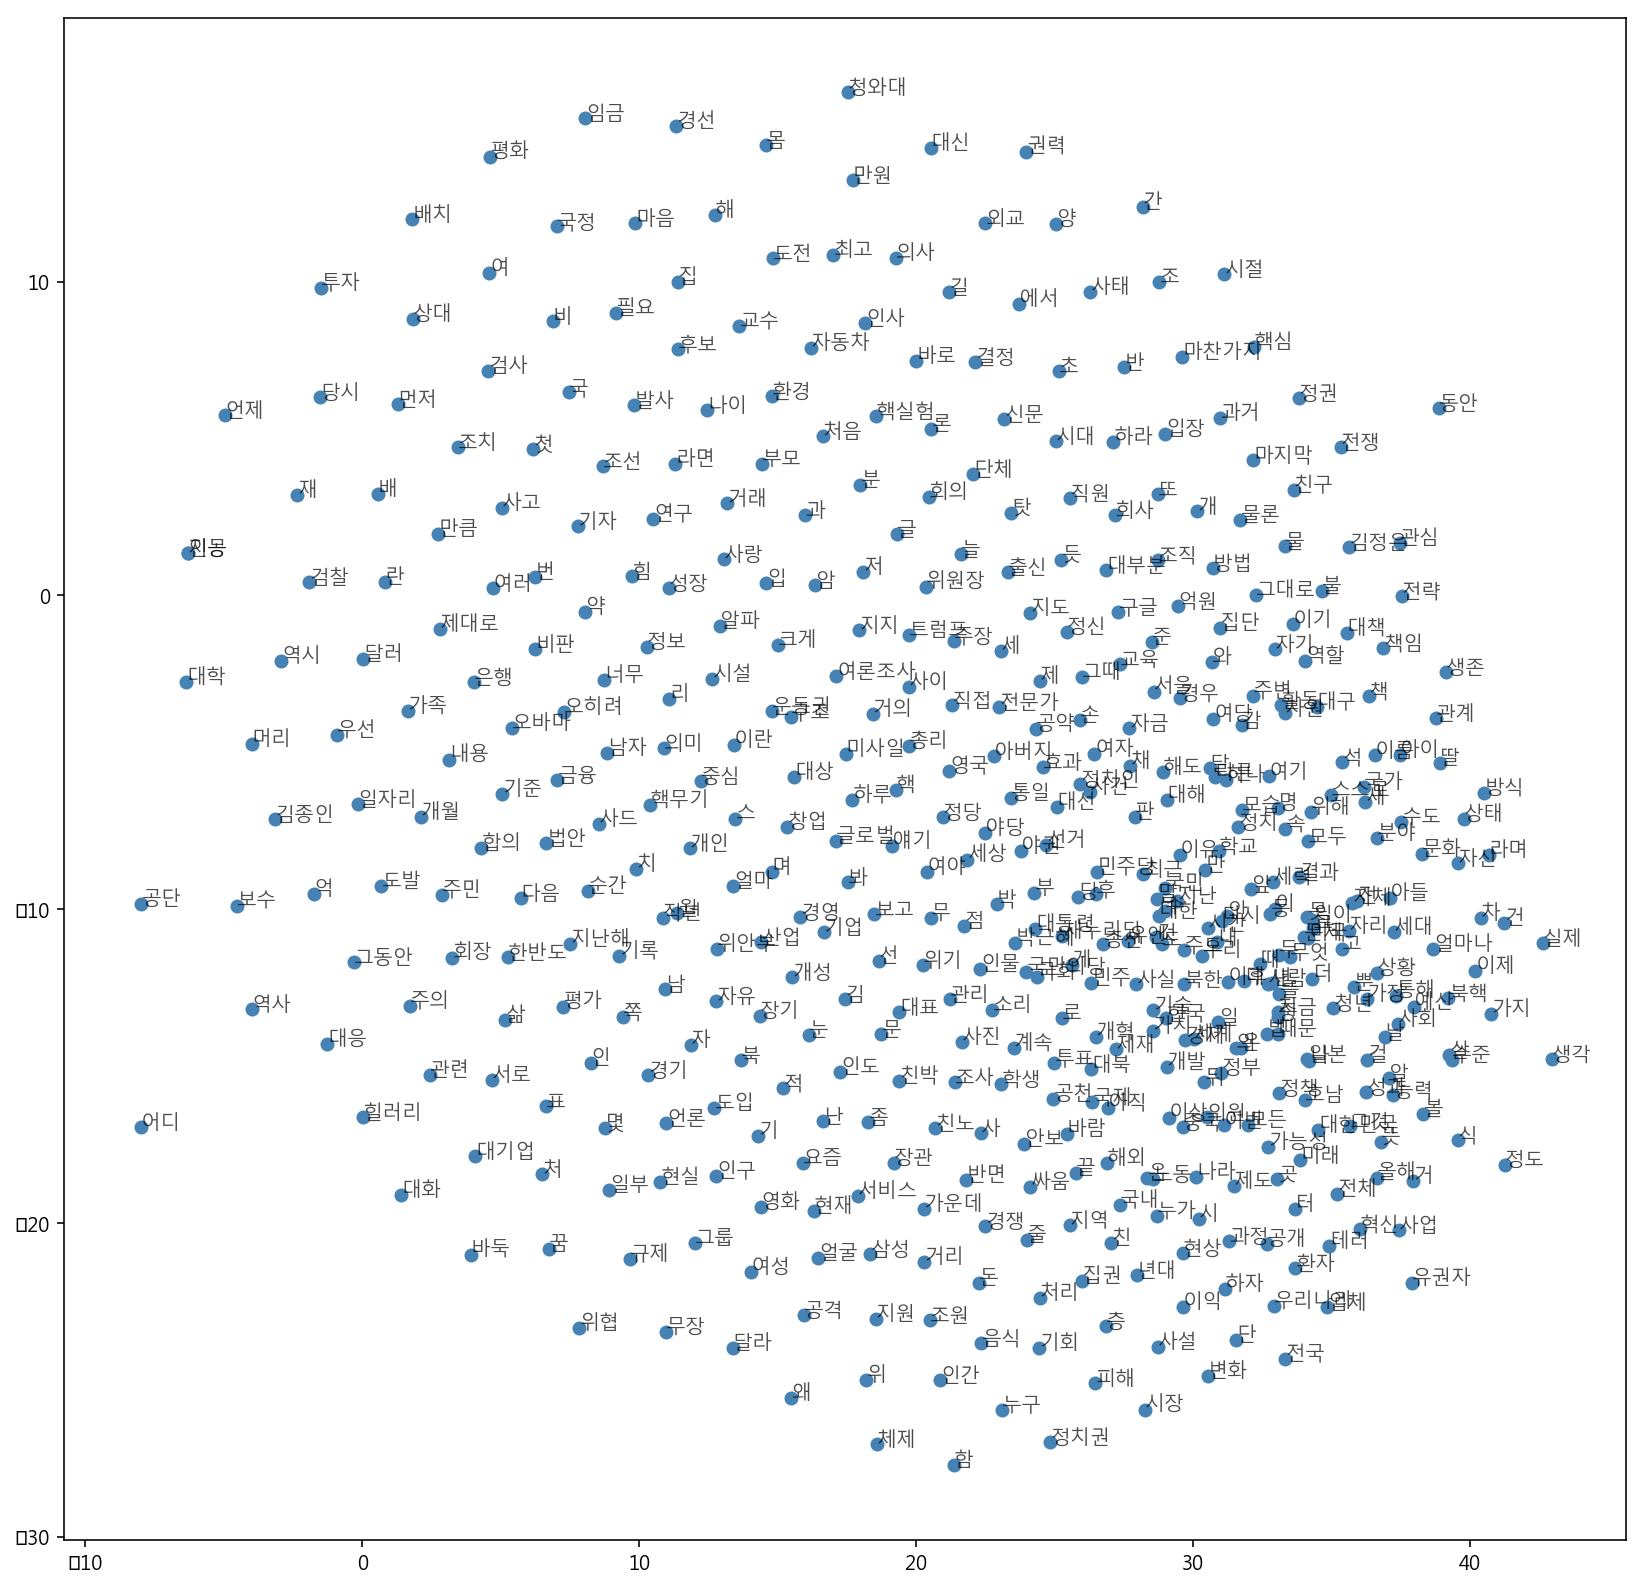

In [40]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [39]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)